Welcome to the code for the synthetic example referenced in the paper <paper title>. 

This code includes randomly generated sampling points, so no two results will be the same.
Enjoy!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cvxpy as cvx

Step 1: Generating the original wave and subsampling it.

In [2]:
#Variables to adjust
samplerate = 20  #in percent (%)
noiseSTD = 0.9 # Low noise = 0.1; #for high noise = 0.9
filename = 'Results'

#generate original signal
cycles = 2 # how many sine cycles
cycles2 =12 # how many sine cycles
cycles3 = 20 # how many sine cycles
resolution = 2000 # how many datapoints to generate

length = np.pi * 7 * cycles
length2 = np.pi * 12 * cycles2
length3 = np.pi * 20 * cycles3

o_wave1 = np.sin(np.arange(0, length, length / resolution))
o_wave2 = np.sin(np.arange(0, length2, length2 / resolution)+3)
o_wave3 = np.sin(np.arange(0, length3, length3 / resolution)+10)
o_wave = o_wave1 + o_wave2 + o_wave3 

time = np.linspace(0,200,resolution)

#adding noise to origial signal
noise = np.random.normal(0,noiseSTD,resolution)
noise = np.zeros(np.shape(o_wave)) + noise #for plotting noise

n_wave = o_wave + noise #adding noise to original wave to generate noisy wave

#frequency of original and noisy waves
n_waved = spfft.dct(n_wave, norm='ortho', axis=0)
o_waved = spfft.dct(o_wave, norm='ortho', axis=0)
freq = np.arange(len(n_waved))/time[-1]

#randomly sample the data
m= int(resolution*(samplerate/100))
ri = np.random.choice(resolution,m,replace=False)
ri.sort()
t2 = np.copy(time[ri])
y2 = np.copy(n_wave[ri])
y3 = np.copy(y2)

Step 2: Reconstructing the waveforms using BP and BPD

In [3]:

ydct = spfft.idct(y2, norm = 'ortho',axis=0)
ydct[0]=0

mean = np.mean(y3)
y3 -= mean

m2=np.copy(y3)
n=np.size(n_wave)


#constructing sampling matrix A
A = spfft.idct(np.identity(resolution), norm='ortho', axis=0) 
A = np.copy(A[ri,:]) 


#BP Reconstruction
vx = cvx.Variable(resolution) #Full res size
constraints = [A@vx == m2]
objective = cvx.Minimize(cvx.norm(vx, 1)) 

#Res to low data ## finding a minimized solution to this equation. 
prob = cvx.Problem(objective, constraints) #defining the problem
result = prob.solve(verbose=True) #solving the problem

x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho',axis=0) #back to time domain.
sig += mean

#getting array of frequencies for the reconstructed data
nfreq = np.arange(len(x))/time[-1]


# BPD Reconstruction
vx_bpd = cvx.Variable(resolution)
epsilon = (noiseSTD**2)*15
constraints_bpd = [cvx.norm(A@vx_bpd - m2,2) <=epsilon]
#objective_bpd = cvx.Minimize(0.5*((cvx.norm(A@vx_bpd - m2,2))**2) + 0.9*(cvx.norm(vx_bpd,1)))
objective_bpd = cvx.Minimize(cvx.norm(vx_bpd,1))
prob_bpd = cvx.Problem(objective_bpd, constraints_bpd) #defining the problem
result_bpd = prob_bpd.solve(verbose=True) #solving the problem

x_bpd = np.array(vx_bpd.value)
x_bpd = np.squeeze(x_bpd)
sig_bpd = spfft.idct(x_bpd, norm='ortho',axis=0) #back to time domain.
sig_bpd += mean

#getting array of frequencies for the reconstructed data
nfreq_bpd= np.arange(len(x_bpd))/time[-1]

#getting ymin/ymax for plotting purposes
ymax = np.max(n_wave)
ymin = np.min(n_wave)
if ymax > abs(ymin):
    yax = ymax + 0.5
else:
    yax = abs(ymin) +0.5

ymax2 = np.max(n_waved)
ymin2 = np.min(n_waved)

if ymax2 > abs(ymin2):
    yax2 = ymax2 + 0.5
else:
    yax2 = abs(ymin2) +0.5   

print('Reconstruction complete, proceed to next step')

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Apr 17 11:52:17 AM: Your problem has 2000 variables, 400 constraints, and 0 parameters.
(CVXPY) Apr 17 11:52:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 11:52:17 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 11:52:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 11:52:17 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 11:52:17 AM: Compiling problem (target solver=CLARABE

Step 3: Plotting and saving results

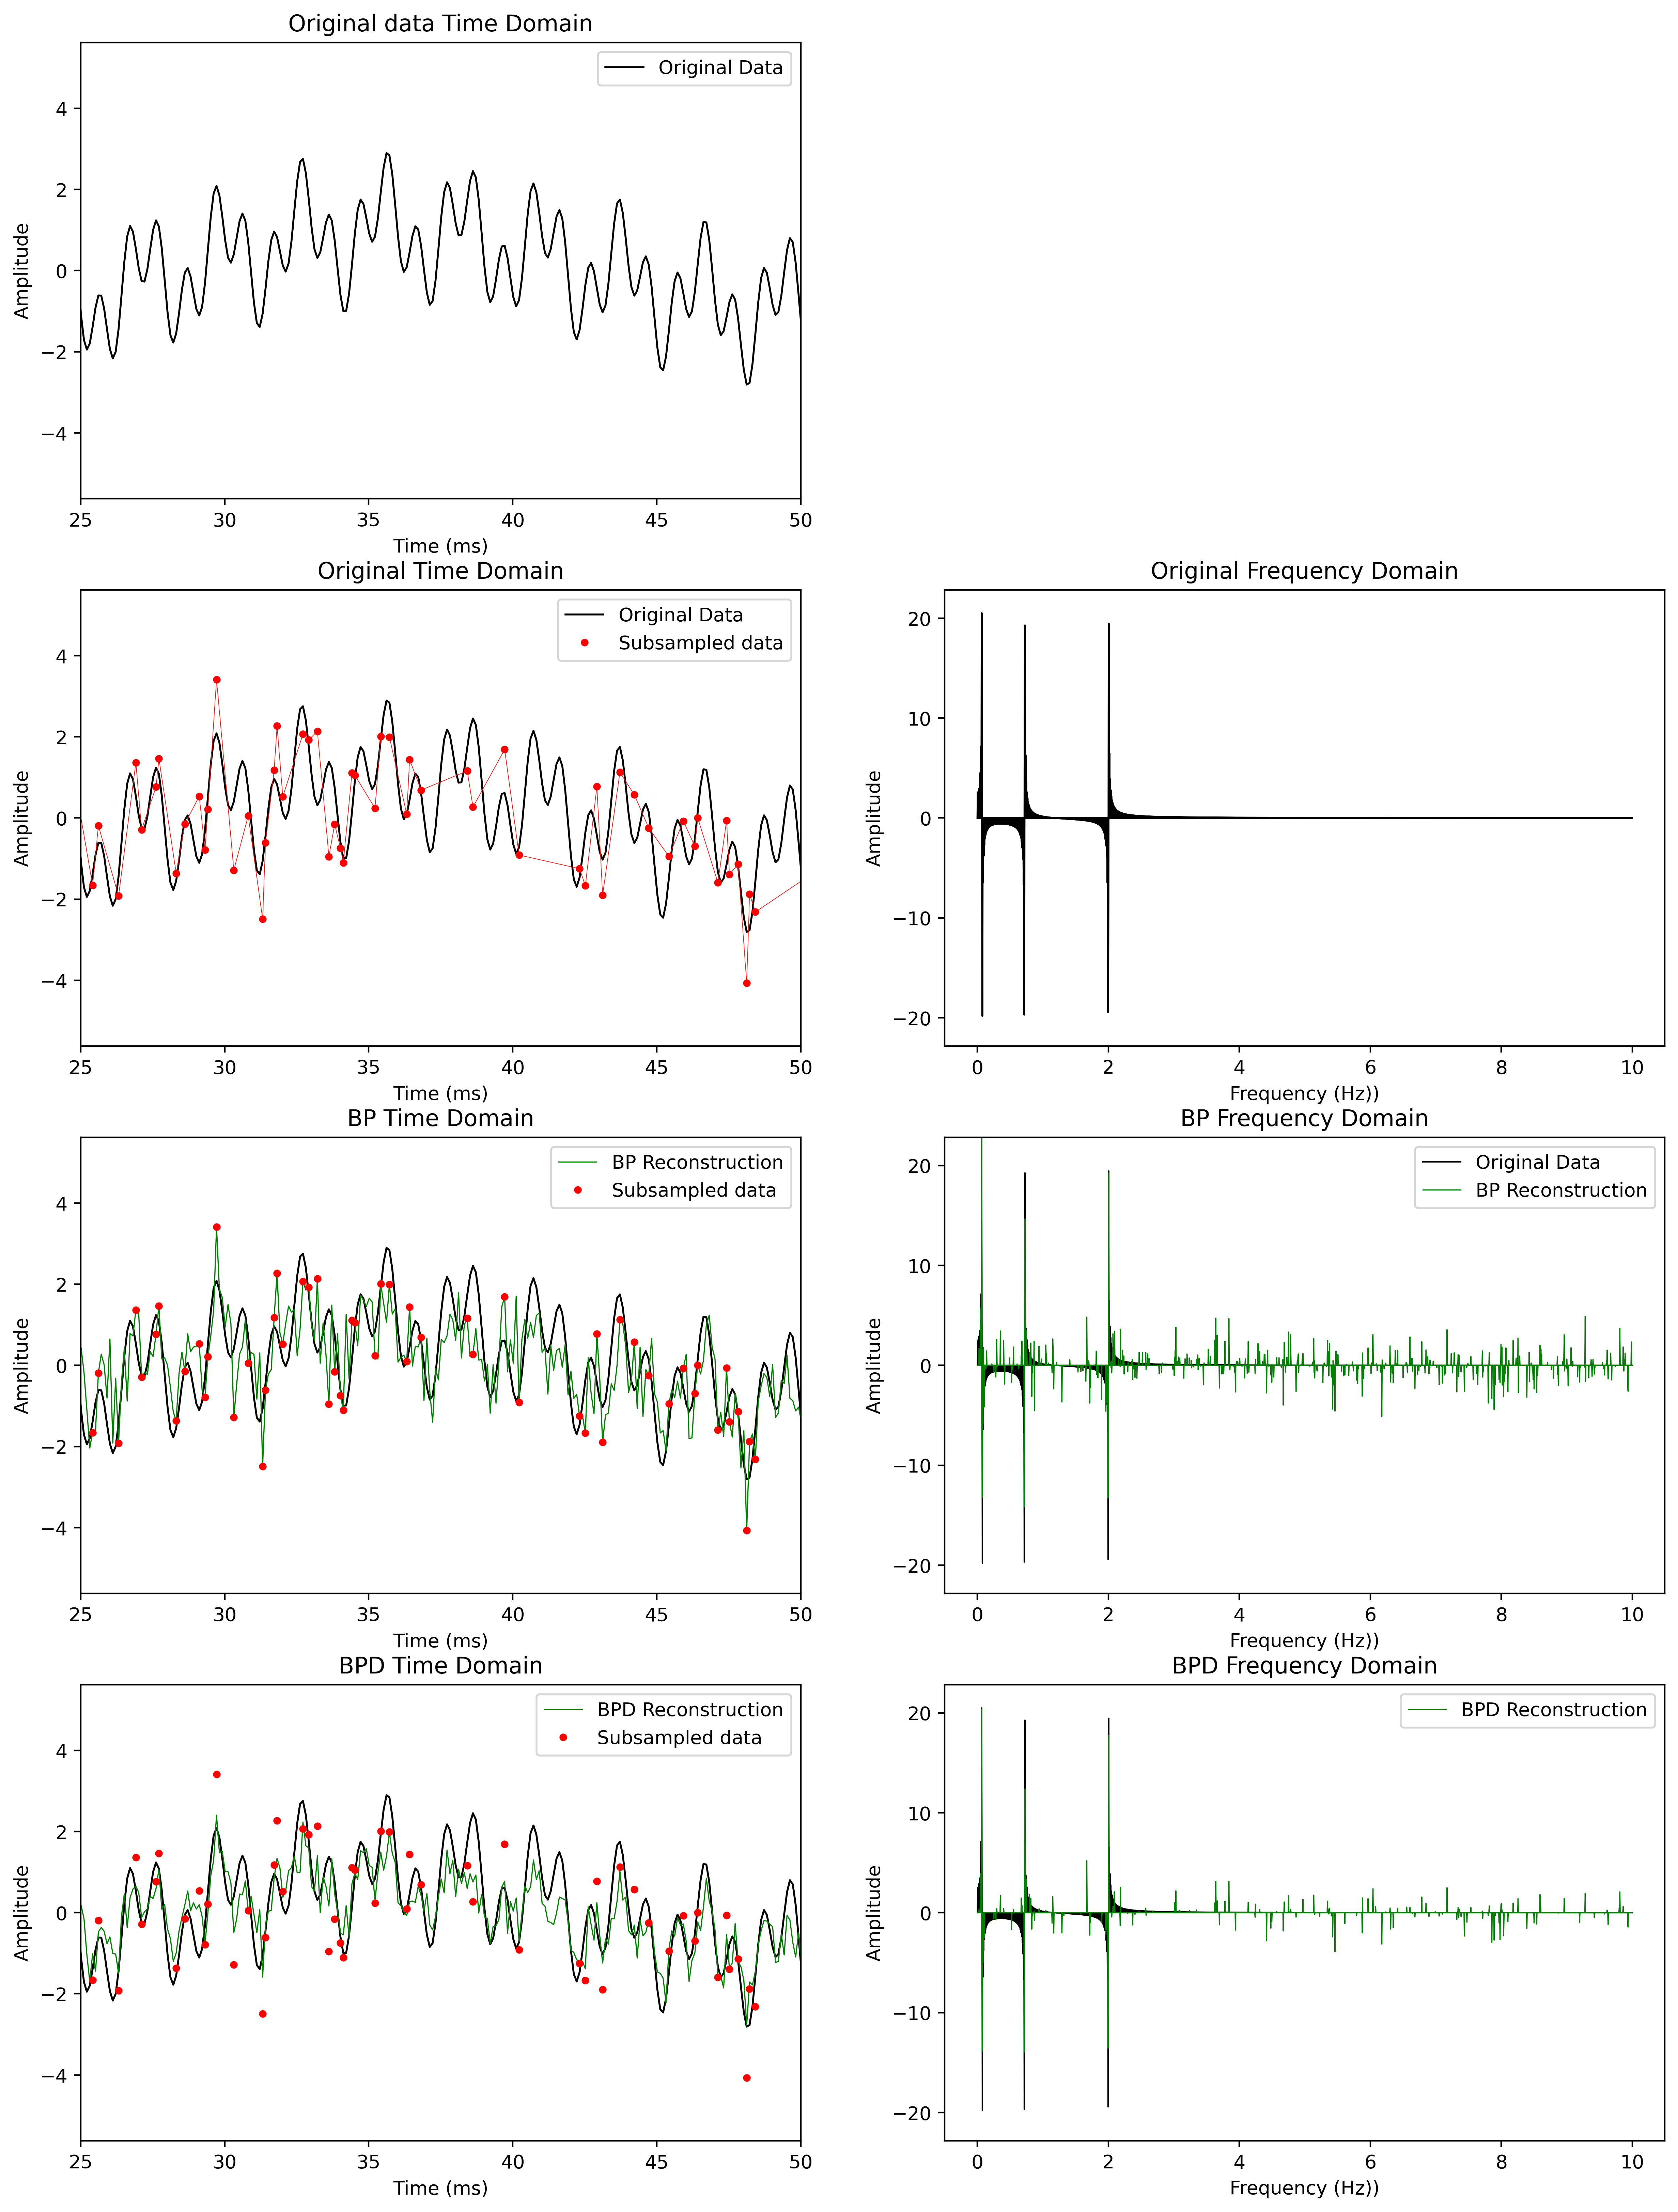

In [5]:
#plotting original signal with and without noise
plt.figure(figsize=(15,15), dpi=400)


#plot time and frequency domain data original
plt.subplot(321)
plt.plot(time, o_wave, 'k', linewidth = 1, label = 'Original Data')
plt.plot(t2,y2,'ro',linewidth = 2.5, label = 'Subsampled data',markersize=3.0)
plt.plot(t2,y2,'r', linewidth=0.3)
plt.title(f'Original Time Domain')
plt.legend()
plt.ylim(-1*yax,yax)
plt.xlim(25,50)
#plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(322)
plt.plot(freq,o_waved, 'k', linewidth = 1, label = 'Original Data' )
plt.title(f'Original Frequency Domain')
plt.ylim(-1*yax2,yax2)
#plt.xlabel('Frequency (Hz))')
plt.ylabel('Amplitude')


## Plotting BP results
plt.subplot(323)
plt.plot(time, o_wave, 'k', linewidth = 1)
plt.plot(time, sig, 'g', linewidth = 0.6, label = 'BP Reconstruction')
#plt.plot(samplespresent(t2, y2, time, sig)[2], samplespresent(t2, y2, time, sig)[3], 'ro', linewidth = 0.5,markersize=3.0)
#plt.plot(samplespresent(t2, y2, time, sig)[0], samplespresent(t2, y2, time, sig)[1],'bo',linewidth = 0.5, label = 'Subsampled data',markersize=3.0)
plt.plot(t2,y2,'ro',linewidth = 2.5, label = 'Subsampled data',markersize=3.0)
plt.title(f'BP Time Domain')
plt.legend()
plt.ylim(-1*yax,yax)
plt.xlim(25,50)
#plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(324)
plt.plot(freq,o_waved, 'k',linewidth = 0.7,label = 'Original Data')
plt.plot(nfreq, x, 'g', linewidth = 0.6, label = 'BP Reconstruction')
plt.legend()
plt.title(f'BP Frequency Domain')
plt.ylim(-1*yax2,yax2)
#plt.xlabel('Frequency (Hz))')
plt.ylabel('Amplitude')


## Plotting BPD results
plt.subplot(325)
plt.plot(time, o_wave, 'k', linewidth = 1)
plt.plot(time, sig_bpd, 'g', linewidth = 0.6, label = 'BPD Reconstruction')
#plt.plot(samplespresent(t2, y2, time, sig_bpd)[2], samplespresent(t2, y2, time, sig_bpd)[3], 'ro', linewidth = 0.5,markersize=3.0)
#plt.plot(samplespresent(t2, y2, time, sig_bpd)[0], samplespresent(t2, y2, time, sig_bpd)[1],'bo',linewidth = 0.5, label = 'Subsampled data',markersize=3.0)
plt.plot(t2,y2,'ro',linewidth = 2.5, label = 'Subsampled data',markersize=3.0)
plt.title(f'BPD Time Domain')
plt.legend()
plt.ylim(-1*yax,yax)
plt.xlim(25,50)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(326)
plt.plot(freq,o_waved, 'k',linewidth = 0.7, label = 'Original Data')
plt.plot(nfreq_bpd, x_bpd, 'g', linewidth = 0.6, label = 'BPD Reconstruction')
plt.legend()
plt.title(f'BPD Frequency Domain')
plt.ylim(-1*yax2,yax2)
plt.xlabel('Frequency (Hz))')
plt.ylabel('Amplitude')
plt.savefig(f"{filename}.png")
#np.savetxt(f"{filename}_CS.dat",np.c_[time,sig])
#np.savetxt(f"{filename}_BPD.dat",np.c_[time,sig_bpd])

plt.show()